<a href="https://colab.research.google.com/github/jsteward2930/Python-Notebooks-for-Physical-Chemistry/blob/main/tutorial_learning_to_smell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the data and install the dependencies

**References:**
https://stackoverflow.com/questions/63152656/installing-rdkit-in-google-colab

In [ ]:
!pip install numpy matplotlib pandas scikit-learn tensorflow gdown
!gdown https://drive.google.com/uc?id=1McblfXbazPNWpWyU7gYEAzZrK88yBZ7K
!unzip data.zip

In [ ]:
!wget -q -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -q -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer

## Introduction

**SMILES** (Simplified Molecular Input Line Entry System) is a chemical notation in string format that allows a user to represent a chemical structure in a way that can be used by the computer.  SMILES supports all elements in the periodic table.

- Upper case letters refer to non-aromatic atoms; lower case letters refer to aromatic atoms. If the atomic symbol has more than one letter the second letter must be lower case.
- The structures that are entered using SMILES are hydrogen-suppressed, the molecules are represented without hydrogens.
- A branch from a chain is specified by placing the SMILES symbol(s) for the branch between parenthesis.
- The number of charges on an atom may be explicitly stated ({-1}) or not ({-}) with curly brackets.
- Atomic bonds are denoted as follows:

| Bond type   |  Symbol|
|----------|:-------------:|
|Single bond |    -   |
| Double bond |    =   |
| Triple bond |    #   |
| Aromatic bond |    *   |
| Disconnected structures |    .   |

**Reference:** https://archive.epa.gov/med/med_archive_03/web/html/smiles.html

This tutorial is divided into four main sections:  
* Setup
* Data exploration  
* Training and test set generation
* Model building
* Model evaluation

### i) Setup

- Set environment seeds to ensure experiment reproducibility
- Load training and test sets and the vocabulary

In [ ]:
# Set environment seeds
RANDOM_SEED = 17
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
# Training and test set paths
TRAINING_DATASET_PATH = "data/train.csv"
TEST_DATASET_PATH = "data/test.csv"

# Vocabulary path
VOCABULARY_PATH = "data/vocabulary.txt"

In [ ]:
# Load datasets and vocabulary
train_df = pd.read_csv(TRAINING_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

vocabulary = open(VOCABULARY_PATH).read().split()

In [ ]:
# Training set preview
train_df.head()

,SMILES,SENTENCE
0,C/C=C/C(=O)C1CCC(C=C1C)(C)C,"fruity,rose"
1,COC(=O)OC,"fresh,ethereal,fruity"
2,Cc1cc2c([nH]1)cccc2,"resinous,animalic"
3,C1CCCCCCCC(=O)CCCCCCC1,"powdery,musk,animalic"
4,CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C,"coniferous,camphor,fruity"


### ii) Data Exploration
- What are the most / least common odors?
- What does the data distribution look like?
- Are all odors represented in the training set?

In [ ]:
# Get a flattened list of all labels
labels = [label.split(',') for label in train_df.SENTENCE.tolist()]
labels = [item for sublist in labels for item in sublist]

# Count the number of occurances for each label
counts = dict((x, labels.count(x)) for x in set(labels))
counts

{'alcoholic': 22,
 'aldehydic': 109,
 'alliaceous': 94,
 'almond': 64,
 'ambergris': 22,
 'ambery': 75,
 'ambrette': 8,
 'ammoniac': 8,
 'animalic': 106,
 'anisic': 46,
 'apple': 133,
 'balsamic': 273,
 'banana': 47,
 'berry': 153,
 'blackcurrant': 49,
 'blueberry': 6,
 'body': 38,
 'bread': 17,
 'burnt': 130,
 'butter': 50,
 'cacao': 75,
 'camphor': 168,
 'caramellic': 120,
 'cedar': 33,
 'cheese': 54,
 'chemical': 115,
 'cherry': 33,
 'cinnamon': 48,
 'citrus': 213,
 'clean': 71,
 'clove': 32,
 'coconut': 45,
 'coffee': 63,
 'cognac': 12,
 'coniferous': 52,
 'cooked': 51,
 'cooling': 63,
 'cucumber': 19,
 'dairy': 80,
 'dry': 112,
 'earthy': 249,
 'ester': 41,
 'ethereal': 216,
 'fatty': 171,
 'fennel': 7,
 'fermented': 65,
 'floral': 634,
 'fresh': 504,
 'fruity': 892,
 'geranium': 43,
 'gourmand': 38,
 'grape': 41,
 'grapefruit': 45,
 'grass': 81,
 'green': 569,
 'herbal': 576,
 'honey': 85,
 'hyacinth': 45,
 'jasmin': 74,
 'lactonic': 36,
 'leaf': 95,
 'leather': 49,
 'lemon': 97,

In [ ]:
# 10 most common labels
most_common = sorted(counts.items(), key=lambda x:-x[1])[:10]

for x in most_common:
    print("{}: {}".format(x[0], x[1]))

fruity: 892
floral: 634
woody: 593
herbal: 576
green: 569
fresh: 504
sweet: 455
resinous: 376
spicy: 315
balsamic: 273


In [ ]:
# 10 least common labels
least_common = sorted(counts.items(), key=lambda x:-x[1], reverse=True)[:10]

for x in least_common:
    print("{}: {}".format(x[0], x[1]))

blueberry: 6
fennel: 7
ammoniac: 8
ambrette: 8
overripe: 10
cognac: 12
bread: 17
plastic: 18
cucumber: 19
ripe: 20


In [ ]:
# Check if any labels are not included in the training set
[label for label in labels if label not in vocabulary]

[]

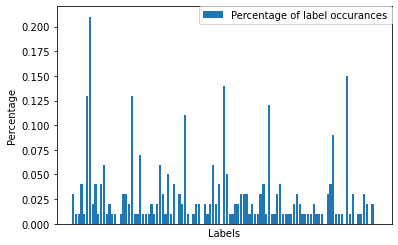

In [ ]:
# Plot the representation percentage of labels in the training seet
keys = counts.keys()
vals = counts.values()

vals_perc = [round(val/len(train_df), 2) for val in vals]
fr = plt.bar(keys, vals_perc, label="Percentage of label occurances")

plt.ylabel('Percentage')
plt.xlabel('Labels')
plt.xticks([])
plt.legend(bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

**Notes:** As can be seen in the analysis above, the dataset is highly imbalanced. While this notebook doesn't cover it, it might be useful to experiment with data augmentation techniques or perform a more in-depth analysis of the under-represented labels.

### iii) Training and Test Set Generation
We need to convert the SMILES string into a format we can work it. In this notebook, we will use the Morgan Fingerprints of the molecules to convert the SMILES data to 256 bits. Molecular fingerprints are one of the ways to represent molecules as mathematical objects (bits).

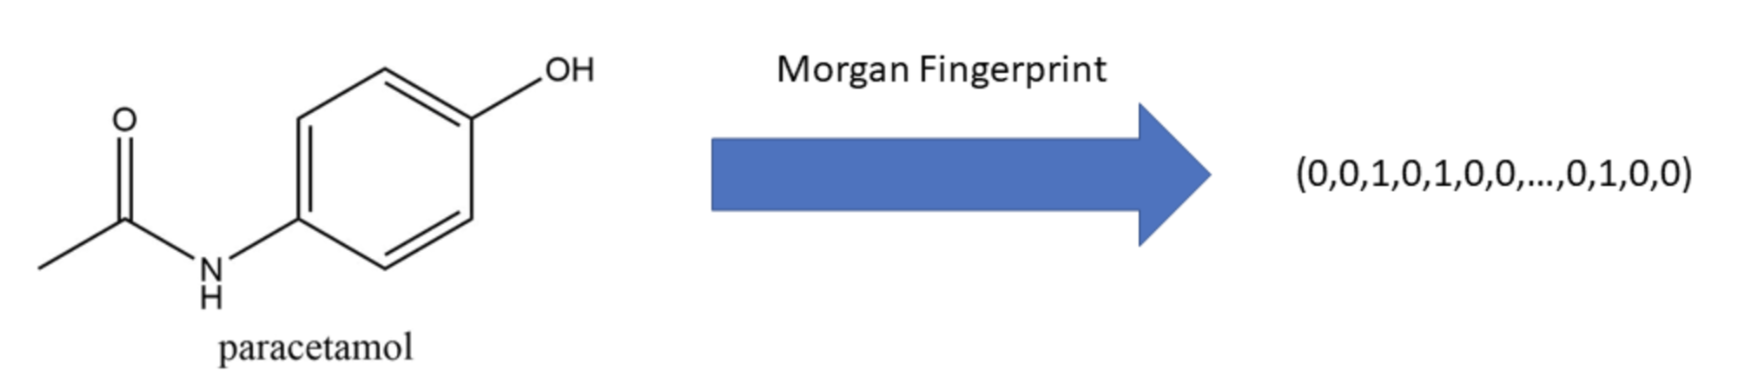

We will also need to process the labels and convert them into a numerical format so that they can be fed into the model. In order to do this, we will:
- Convert the SENTENCE column of the dataframe to a list of lists
- Create a tokenizer with the available vocabulary and assign an integer value to each unique label
- Use the tokenizer to transform the values in the list of lists (of labels) into their respective token ids
- Use scikit-learn's CountVectorizer to convert the label set of each molecule into a one-hot-encoded format.

**References:**  
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf  
https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP  
https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1


In [ ]:
def convert_to_bits(SMILES):
    # Convert SMILES strings into molecules
    mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in SMILES]
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= {}, nBits=256, useChirality=True) for m in mols]

    # Convert training fingerprints into binary
    np_fps = []
    for fp in fps:
      arr = np.zeros((1,), dtype= int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      np_fps.append(arr)
    return np_fps

In [ ]:
# Convert training and test set samples to 256 bits (arrays of size (256, ))
np_fps = convert_to_bits(train_df.SMILES.tolist())
test_np_fps = convert_to_bits(test_df.SMILES.tolist())

In [ ]:
# Print the fingerprint of first training sample
np_fps[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
# Tokenize the vocabulary - assigns a unique id to each odor
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocabulary)
word_index = tokenizer.word_index

# Convert SENTENCE column to a list of lists, replace values with their respective id
labels = [label.split(',') for label in train_df.SENTENCE.tolist()]
labels_arr = []
for label in labels:
    labels_arr.append([word_index[elem] for elem in label])

# Print the labels (integer ids) of the first molecule
print(labels_arr[0])

[49, 90]


In [ ]:
# Training and test inputs
train_x = np.array(np_fps).astype(np.float32)
test_x = np.array(test_np_fps).astype(np.float32)

# Training set labels - vectorize the tokens
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
train_y = vectorizer.fit_transform(train_df.SENTENCE).toarray()

# Index - label map
ind2word = {i: x for i, x in enumerate(vectorizer.get_feature_names())}
print(ind2word)

{0: 'alcoholic', 1: 'aldehydic', 2: 'alliaceous', 3: 'almond', 4: 'ambergris', 5: 'ambery', 6: 'ambrette', 7: 'ammoniac', 8: 'animalic', 9: 'anisic', 10: 'apple', 11: 'balsamic', 12: 'banana', 13: 'berry', 14: 'blackcurrant', 15: 'blueberry', 16: 'body', 17: 'bread', 18: 'burnt', 19: 'butter', 20: 'cacao', 21: 'camphor', 22: 'caramellic', 23: 'cedar', 24: 'cheese', 25: 'chemical', 26: 'cherry', 27: 'cinnamon', 28: 'citrus', 29: 'clean', 30: 'clove', 31: 'coconut', 32: 'coffee', 33: 'cognac', 34: 'coniferous', 35: 'cooked', 36: 'cooling', 37: 'cucumber', 38: 'dairy', 39: 'dry', 40: 'earthy', 41: 'ester', 42: 'ethereal', 43: 'fatty', 44: 'fennel', 45: 'fermented', 46: 'floral', 47: 'fresh', 48: 'fruity', 49: 'geranium', 50: 'gourmand', 51: 'grape', 52: 'grapefruit', 53: 'grass', 54: 'green', 55: 'herbal', 56: 'honey', 57: 'hyacinth', 58: 'jasmin', 59: 'lactonic', 60: 'leaf', 61: 'leather', 62: 'lemon', 63: 'lily', 64: 'liquor', 65: 'meat', 66: 'medicinal', 67: 'melon', 68: 'metallic', 69

### iv) Model Building
For this part we will build a simple multinomial logistic regression model with Keras. Since we have 109 unique labels, this model will output the probability of each label, with their sums equaling to 1:
$\sum_{i=0}^{109} p(i) = 1$

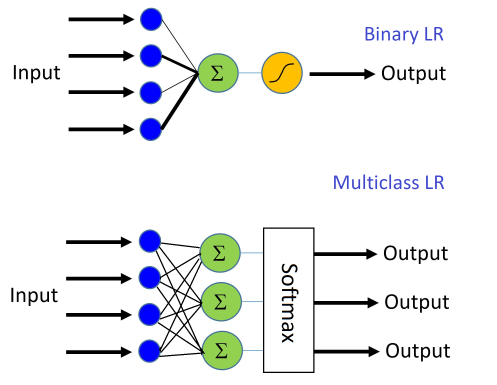

In [ ]:
# Print input and target shapes of the training data
print(train_x.shape)
print(train_y.shape)

(4316, 256)
(4316, 109)


In [ ]:
# Number of unique labels
N_OUTPUT = 109

# Number of epochs and batch size
N_EPOCHS = 50
BATCH_SIZE = 32

# Define logistic regression model
model = Sequential()
model.add(Dense(N_OUTPUT, input_dim=256, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Start training
model.fit(train_x, train_y, validation_split=0.1, batch_size=BATCH_SIZE, epochs= N_EPOCHS, shuffle=True, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 109)               28013     
Total params: 28,013
Trainable params: 28,013
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
122/122 [==============================] - 0s 3ms/step - loss: 12.8567 - accuracy: 0.0386 - val_loss: 12.4972 - val_accuracy: 0.0718
Epoch 2/50
122/122 [==============================] - 0s 1ms/step - loss: 11.8246 - accuracy: 0.0613 - val_loss: 12.1975 - val_accuracy: 0.0787
Epoch 3/50
122/122 [==============================] - 0s 1ms/step - loss: 11.5762 - accuracy: 0.0716 - val_loss: 12.2080 - val_accuracy: 0.0833
Epoch 4/50
122/122 [==============================] - 0s 2ms/step - loss: 11.5157 - accuracy: 0.0767 - val_loss: 12.2896 - val_accuracy: 0.0949
Epoch 5/50
122/122 [==============================] - 0s 1ms/step - lo

### v) Model Evaluation

Finally, we will evaluate the model and create a submission file with the following steps:
- Predict on the test set
- For each sample, filter the top 15 predictions (labels) and sort them by their probability
- Use the top 15 labels to generate 5 sets of 3 labels for each input sample
- Predict on the training set and compute the average Jaccard Index / Tanimoto Similarity Score for the top-5 proposed sentences

In [ ]:
# Predict on the test set
preds = model.predict(test_x)

# Choose the top 15 predictions for each sample and group by 3
preds_clean = []
for i in range(preds.shape[0]):
    labels = [ind2word[i] for i in list(preds[i, :].argsort()[-15:][::-1])]

    labels_seq = []
    for i in range(0, 15, 3):
        labels_seq.append(",".join(labels[i:(i+3)]))

    preds_clean.append(";".join(labels_seq))

In [ ]:
# Top-5 proposed sentences for the first test sample
preds_clean[0]

'fruity,woody,resinous;herbal,fresh,balsamic;green,floral,camphor;sweet,tropicalfruit,berry;ethereal,spicy,earthy'

**Note:** Since we are following a one-vs-rest classification approach, the predicted labels are not grouped together. Hence, each label occurs only once in any set of top-5 proposed sentences.

In [ ]:
# Compute the jaccard index
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
# Compute the jaccard index / TSS of the training set predictions
train_labels = [label.split(',') for label in train_df.SENTENCE.tolist()]
train_preds = model.predict(train_x)

jaccard_scores = []
for i in range(train_preds.shape[0]):
    _preds = [ind2word[i] for i in list(train_preds[i, :].argsort()[-15:][::-1])]
    _true = train_labels[i]

    # Compute the jaccard index of each prediction set (e.g. ['woody', 'fruity', 'resinous'])
    scores = [jaccard_index(_true, _preds[j:(j+3)]) for j in range(0, 15, 3)]
    jaccard_scores.append(max(scores))

score = sum(jaccard_scores) / len(jaccard_scores)
print("Top-5 TSS: {}".format(round(score, 3)))

Top-5 TSS: 0.298


In [ ]:
# Create the submission.csv file
test_df["PREDICTIONS"] = preds_clean
test_df.to_csv("submission.csv",index=False)